In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
import os
import seaborn as sns

%matplotlib inline

/root/miniconda/envs/rep_py2/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [9]:
train = pd.read_csv('/notebooks/data/MC2015Sim09Dev03/TrainMixture/TrainPhysTks-EvalPhysTks-NoReweight-EqualMix/GhostAccFrac1.0/XGBoost-Run2-NoTkLikCD/Long/data_train.csv')
train = train.loc[train['VeloCharge'] != 'VeloCharge']
train.drop(['Unnamed: 0'], axis=1, inplace=1)

for col in train:
    try:
        train[col] = train[col].astype(float)
    except:
        train[col] = train[col].astype(bool)
train.to_csv('data/equal_mix_train.csv', index=0)

In [14]:
train = pd.read_csv('data/equal_mix_train.csv')

part_codes = {'Ghost':0, 'Electron':11, 'Muon':13, 'Pion':211, 'Kaon':321, 'Proton':2212}
particles = ["Ghost", "Electron", "Muon", "Pion", "Kaon", "Proton"]

train.loc[~train['MCParticleType'].abs().isin(part_codes.values()), 'MCParticleType'] = 0

train_types = np.abs(train['MCParticleType'])
train_types_encoding = {part_codes[code]:index for index, code in enumerate(particles)}
labels = train_types.apply(lambda x: train_types_encoding[x])

mc_features = ['HasMC', 'MCParticleType', 'MCParticleP', 'MCParticlePt', 'MCVirtualMass', 
               'MCFromB', 'MCFromD', 'MCVertexType', 'MCVertexX', 'MCVertexY', 'MCVertexZ', 
               'piplus_OWNPV_X', 'piplus_OWNPV_Y', 'piplus_OWNPV_Z', 'piplus_OWNPV_XERR', 
               'piplus_OWNPV_YERR', 'piplus_OWNPV_ZERR', 'piplus_OWNPV_CHI2', 'piplus_OWNPV_NDOF', 
               'piplus_IP_OWNPV', 'piplus_IPCHI2_OWNPV', 'nCandidate', 'totCandidates', 'EventInSequence', 
               'TrackHistory', 'TrackType', 'RecoPIDcode']

constant_features = ['TrackMatchChi2', 'TrackCloneDist', 'RichUsedAero']

features = list(set(train.columns) - set(mc_features + constant_features))

train = train.loc[:, features]

print train.shape
print features

(300000, 77)
['RichDLLpi', 'RichDLLe', 'CaloBremChi2', 'RichDLLp', 'HcalPIDe', 'RichAbovePiThres', 'InAccHcal', 'CaloElectronMatch', 'InAccEcal', 'TrackFitTChi2', 'NumUpstreamTracks', 'CaloBremMatch', 'NumProtoParticles', 'MuonIsLooseMuon', 'InAccSpd', 'CaloEcalChi2', 'MuonMuLL', 'TrackFitVeloNDoF', 'TrackLikelihood', 'CaloSpdE', 'RichAboveKaThres', 'EcalPIDe', 'CaloNeutralSpd', 'CombDLLmu', 'CombDLLpi', 'TrackGhostProbability', 'CaloTrMatch', 'MuonNShared', 'RichAboveMuThres', 'CaloNeutralEcal', 'RichAboveElThres', 'EcalPIDmu', 'NumMuonTracks', 'TrackFitVeloChi2', 'NumSPDHits', 'InAccPrs', 'CombDLLe', 'CombDLLk', 'CaloChargedSpd', 'NumDownstreamTracks', 'CaloEcalE', 'CaloClusChi2', 'CaloNeutralPrs', 'RichDLLbt', 'BremPIDe', 'CombDLLp', 'RichUsedR2Gas', 'InAccBrem', 'HcalPIDmu', 'TrackNumDof', 'PrsPIDe', 'RichDLLk', 'NumCaloHypos', 'VeloCharge', 'NumLongTracks', 'RichUsedR1Gas', 'NumRich1Hits', 'TrackP', 'CaloChargedPrs', 'MuonBkgLL', 'RichAbovePrThres', 'TrackFitMatchChi2', 'TrackFitT

In [33]:
from sklearn.cross_validation import train_test_split

lvl1_idx, lvl2_idx = train_test_split(train.index, test_size=0.5, random_state=42)
train_lvl1 = train.loc[lvl1_idx]
labels_lvl1 = labels[lvl1_idx]
train_lvl2 = train.loc[lvl2_idx]
labels_lvl2 = labels[lvl2_idx]

del train

NameError: name 'train' is not defined

In [34]:
from sklearn.preprocessing import Imputer

to_log = ['CaloNeutralPrs', 'CaloPrsE', 'CaloHcalE', 'CaloNeutralEcal', 'CaloTrMatch', 'CaloElectronMatch', 'CaloChargedPrs',
          'MuonNShared', 'CaloBremMatch', 'TrackPt', 'TrackP', 'NumDownstreamTracks', 'CaloEcalChi2', 'NumRich1Hits',
          'NumMuonTracks', 'NumTTracks', 'TrackFitMatchChi2', 'TrackDOCA', 'CaloClusChi2', 'TrackFitVeloChi2',
          'CaloBremChi2', 'CaloChargedEcal', 'NumSPDHits', 'NumVeloTracks', 'TrackFitVeloNDoF', 'TrackFitTChi2', 'NumRich2Hits', ]

to_log_negative = ['CaloTrajectoryL', 'MuonMuLL', 'RichDLLbt', 'CombDLLp', 'RichDLLe', 'TrackLikelihood', 'CombDLLk', 
                   'RichDLLp', 'CaloEcalE', 'RichDLLmu', 'RichDLLk']

# CaloChargedSpd - 1 or -999
# CombDLLpi, RichDLLpi  0 or -999

def log1p_negative(array):
    negative = array < 0
    array = np.log1p(np.abs(array))
    array[negative] *= -1
    return array

def preprocess_data(X):
    X.loc[:, 'CaloChargedSpd'].replace(-999, 0, inplace=1)
    X.loc[:, ['CombDLLpi', 'RichDLLpi']].replace(-999, 1, inplace=1)
    
    X[X == -999] = np.nan
    X_columns = X.columns

    imp = Imputer()
    X = imp.fit_transform(X)
    X = pd.DataFrame(data=X, columns=X_columns)

    for col in to_log:
        X[col] = np.log1p(X[col])
    for col in to_log_negative:
        X[col] = log1p_negative(X[col])
    return X
train_lvl1 = preprocess_data(train_lvl1)
train_lvl2 = preprocess_data(train_lvl2)

In [ ]:
import cPickle as pickle
from rep.estimators import TMVAClassifier

config_path = '/notebooks/data/configs/networks/TMVA-Run2-NoTkLikCDVelodEdx/'
def get_features_for(part_type):
    config_file_name = 'GlobalPID_{0}_Long_ANN.txt'.format(part_type)
    config = np.loadtxt(os.path.join(config_path, config_file_name), dtype='S', comments='#')
    return config[5:]

for index, part_name in enumerate(particles):
    part_labels = (labels_lvl1 == index).astype(int)
    features = get_features_for(part_name)

    tmva_kmlp = TMVAClassifier(method='kMLP',
                       factory_options="V:!Silent:!Color:!DrawProgressBar",
                       features=features,
                       H='true',
                       V='true',
                       EpochMonitoring='true',
                       HiddenLayers=int(1.2*len(features)),                       
                       UseRegulator='true',
                       ConvergenceImprove = "1e-16",
                       ConvergenceTests = "15",
                       VarTransform = "Norm",
                       NCycles = 50,
                       NeuronType = "sigmoid",
                       TrainingMethod = "BP",
                       EstimatorType = "CE")
    tmva_kmlp.fit(train_lvl1, part_labels)
    with open('stack_models/TMVA_kMLP-{0}.p'.format(part_name), 'wb') as pkl:
        pickle.dump(tmva_kmlp, pkl, pickle.HIGHEST_PROTOCOL)
    del tmva_kmlp

In [42]:
params = {}
params['objective'] = 'multi:softprob'
params['eta'] = 0.1
params['max_depth'] = 5
params['num_class'] = 6
params['numrounds'] = 180
params['colsample_bytree'] = 0.65
params['eval_metric'] = 'mlogloss'
params['nthread'] = 3
params['seed'] = 0

xgtrain = xgb.DMatrix(train_lvl1, labels_lvl1)

model = xgb.train(params, xgtrain, num_boost_round=params['numrounds'])
with open('stack_models/xgboost.p', 'wb') as pkl:
    pickle.dump(model, pkl, pickle.HIGHEST_PROTOCOL)

In [54]:
import os 
train_stack = []
with open('stack_models/xgboost.p', 'rb') as pkl:
    xgboost_model = pickle.load(pkl)
xgtrain_lvl2 = xgb.DMatrix(train_lvl2)
train_stack.append(xgboost_model.predict(xgtrain_lvl2))

TMVA_models = {}
for model_name in os.listdir('stack_models/')[1:]:
    with open('stack_models/{0}'.format(model_name), 'rb') as pkl:
        part_name = model_name.split('-')[1].split('.')[0]
        TMVA_models[part_name] = pickle.load(pkl)
    
for part_name in particles:
    train_stack.append(TMVA_models[part_name].predict_proba(train_lvl2)[:, 1].reshape(-1, 1))

In [55]:
train_stack = np.hstack(train_stack)

0.605679333333
140


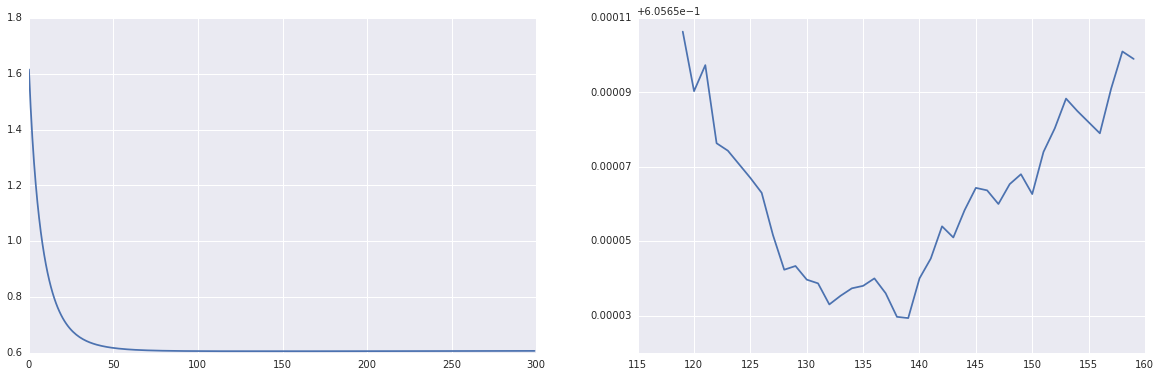

In [64]:
params = {}
params['objective'] = 'multi:softprob'
params['eta'] = 0.1
params['max_depth'] = 4
params['num_class'] = 6
params['numrounds'] = 140
#params['colsample_bytree'] = 0.65
params['eval_metric'] = 'mlogloss'
params['nthread'] = 3
params['seed'] = 0

test_score_col = 'test-{0}-mean'.format(params['eval_metric'])

xgtrain_stack = xgb.DMatrix(train_stack, labels_lvl2)
#t = xgb.cv(params, xgtrain_stack, num_boost_round=params['numrounds'], nfold=3, show_progress=1, show_stdv=0, seed=0)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
ax1.plot(t.index, t[test_score_col])
print t[test_score_col].min()
print t[test_score_col].argmin() + 1

best_iter = t[test_score_col].argmin()
_ = ax2.plot(t.index[best_iter-20:best_iter+21], t.loc[best_iter-20:best_iter+20, test_score_col])

In [85]:
test = pd.read_csv('/notebooks/data/samples_for_comparison/sample_test.csv')
test.drop('Unnamed: 0', axis=1, inplace=1)

part_codes = {'Ghost':0, 'Electron':11, 'Muon':13, 'Pion':211, 'Kaon':321, 'Proton':2212}
particles = ["Ghost", "Electron", "Muon", "Pion", "Kaon", "Proton"]

test.loc[~test['MCParticleType'].abs().isin(part_codes.values()), 'MCParticleType'] = 0

test_types = np.abs(test['MCParticleType'])
labels_test = test_types.apply(lambda x: train_types_encoding[x])

mc_features = ['HasMC', 'MCParticleType', 'MCParticleP', 'MCParticlePt', 'MCVirtualMass', 
               'MCFromB', 'MCFromD', 'MCVertexType', 'MCVertexX', 'MCVertexY', 'MCVertexZ', 
               'piplus_OWNPV_X', 'piplus_OWNPV_Y', 'piplus_OWNPV_Z', 'piplus_OWNPV_XERR', 
               'piplus_OWNPV_YERR', 'piplus_OWNPV_ZERR', 'piplus_OWNPV_CHI2', 'piplus_OWNPV_NDOF', 
               'piplus_IP_OWNPV', 'piplus_IPCHI2_OWNPV', 'nCandidate', 'totCandidates', 'EventInSequence', 
               'TrackHistory', 'TrackType', 'RecoPIDcode']

constant_features = ['TrackMatchChi2', 'TrackCloneDist', 'RichUsedAero']

features = list(set(train_lvl2.columns) - set(mc_features + constant_features))

test = test.loc[:, features]

print test.shape
test = preprocess_data(test)

(100000, 77)


In [81]:
del train_lvl1

In [83]:
import os 
test_stack = []
with open('stack_models/xgboost.p', 'rb') as pkl:
    xgboost_model = pickle.load(pkl)
xgtest = xgb.DMatrix(test)
test_stack.append(xgboost_model.predict(xgtest))
    
for part_name in particles:
    test_stack.append(TMVA_models[part_name].predict_proba(test)[:, 1].reshape(-1, 1))
test_stack = np.hstack(test_stack)

In [91]:
xgtest = xgb.DMatrix(test_stack)
model = xgb.train(params, xgtrain_stack, num_boost_round=params['numrounds'])
preds_test = model.predict(xgtest)

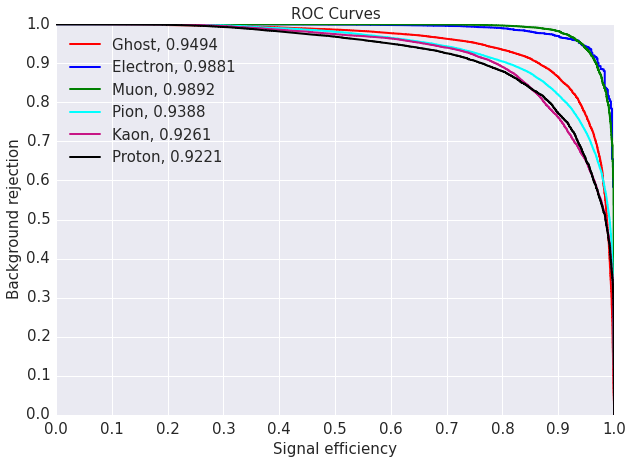

In [93]:
from utils import get_roc_auc_matrix, get_roc_curves

_ = get_roc_curves(labels_test, preds_test, particles)

/root/miniconda/envs/rep_py2/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


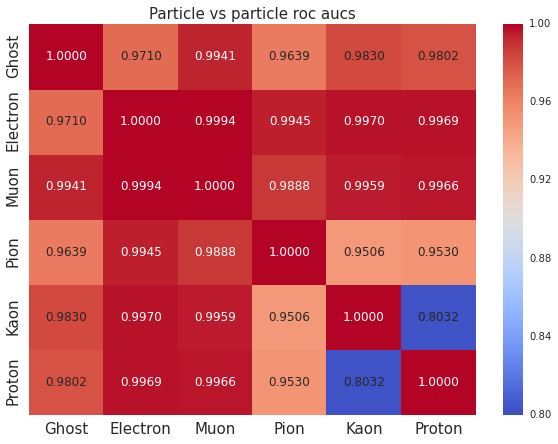

In [94]:
_ = get_roc_auc_matrix(labels_test, preds_test, particles)